In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import squarify

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient

### Parâmetros do matplot e Seaborn

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Recuperação de Datasets do MongoDB

In [ ]:
df_tipos_infracoes_2018 = mongo_to_dataframe("tipos_infracoes_2018")

In [80]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [46]:
df_pedestres_mortos_trechos_ns_2008_2017 = mongo_to_dataframe("pedestres_mortos_trechos_ns_2008_2017")

In [41]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

In [44]:
df_frota_veiculos_2009_2019 = mongo_to_dataframe("frota_veiculos_2009_2019")

In [45]:
df_numero_habilitados_2009_2018 = mongo_to_dataframe("numero_habilitados_2009_2018")

In [33]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [18]:
df_demografia_2015_2016 = mongo_to_dataframe("demografia_brasilia_2015_2016")

In [50]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

In [51]:
df_indice_mortos_transito_2009_2010 = mongo_to_dataframe("indice_mortos_transito_2009_2018")

In [22]:
df_sinalizacao_2018 = mongo_to_dataframe("sinalizacao_2018")

In [125]:
df_equipamentos_fiscalizacao_2018 = mongo_to_dataframe("equipamentos_fiscalizacao_2018")

In [118]:
df_faixas_por_ra_2018 = mongo_to_dataframe("faixas_por_ra_2018")

In [52]:
df_condicoes_rodovias_2018 = mongo_to_dataframe("condicoes_rodovias_2018")

## Análise da relação da distribuição de acidentes graves de trânsito nas regiões administrativas do DF

### Observações

* Comparando o número das populações das cidades com mais acidentes é possível determinar que o tamanho da população está diretamente relacionado com o número de acidentes fatais
* A correlação de pearson mostra uma relação forte, positiva de inclinação 0.92
* O rank das cidades com maiores populações é quase o mesmo das cidades com maior número de acidentes
* A correlação entre o número de acidentes fatais em uma região e sua renda per capita é média e negativa, indicando uma possível proporção inversa (Regiões com rendas maiores tem população menor)
* As correlações mais fortes são diretamente com o número da população, visto que as correlações entre densidade e acidentes são irrelevantes.

In [4]:
df_demografia_2015_2016.head()

,RA,População 2013,População 2015/2016,TMGCA (%),Área com Ocupação Urbana (em ha),Densidade Urbana 2015,Área Total da RA (em ha),Densidade Demográfica 2015,Casas (%),Apart + Quit (%),Distância do Centro (Plano Piloto) em Km,Grupo de Renda,Renda Per Capita 2015
0,RA XXIII - Varjão,9292,8453,-4.62,59.42,142.27,75.56,111.87,75.75,20.44,11,Baixa,627.81
1,RA XIX - Candangolândia,16886,15641,-3.76,113.85,137.38,662.70,23.60,87.20,12.00,11,Média Baixa Renda,1460.98
2,RA IX - Ceilândia,451872,479713,3.03,3691.92,129.94,23401.14,20.50,94.36,4.25,26,Média Baixa Renda,914.61
3,RA XV - Recanto das Emas,138997,146906,2.81,1246.27,117.88,10261.11,14.32,96.98,2.76,26,Média Baixa Renda,803.92
4,RA XIV - São Sebastião,98908,99525,0.31,882.69,112.75,35571.37,2.80,92.71,6.61,26,Média Baixa Renda,966.96


In [5]:
df_demografia_2015_2016 = df_demografia_2015_2016[df_demografia_2015_2016['RA'] != 'DISTRITO FEDERAL - DF']

In [26]:
cidades_mais_populosas = df_demografia_2015_2016.sort_values('População 2015/2016', ascending = False)
cidades_mais_populosas.head(n = 7)

,RA,População 2013,População 2015/2016,TMGCA (%),Área com Ocupação Urbana (em ha),Densidade Urbana 2015,Área Total da RA (em ha),Densidade Demográfica 2015,Casas (%),Apart + Quit (%),Distância do Centro (Plano Piloto) em Km,Grupo de Renda,Renda Per Capita 2015
2,RA IX - Ceilândia,451872,479713,3.03,3691.92,129.94,23401.14,20.50,94.36,4.25,26,Média Baixa Renda,914.61
7,RA XII - Samambaia,228356,258457,6.39,2501.67,103.31,10125.85,25.52,89.29,10.49,25,Média Baixa Renda,914.75
25,RA I - Plano Piloto,216489,210067,-1.49,10176.75,20.64,40989.31,5.12,9.19,90.45,0,Alta,5559.75
14,RA III - Taguatinga,212863,207045,-1.38,2572.11,80.50,8056.15,25.70,69.73,30.00,21,Média Alta Renda,1998.14
18,RA VI - Planaltina,185375,190495,1.37,2989.46,63.72,153847.95,1.24,94.49,4.86,38,Média Baixa Renda,933.8
3,RA XV - Recanto das Emas,138997,146906,2.81,1246.27,117.88,10261.11,14.32,96.98,2.76,26,Média Baixa Renda,803.92
17,RA XX - Águas Claras,118864,138562,7.97,1937.03,71.53,2285.82,60.62,23.06,76.84,19,Média Alta Renda,3339.91


Text(0.5, 1.0, 'Treemap das regiões mais populosas do DF')

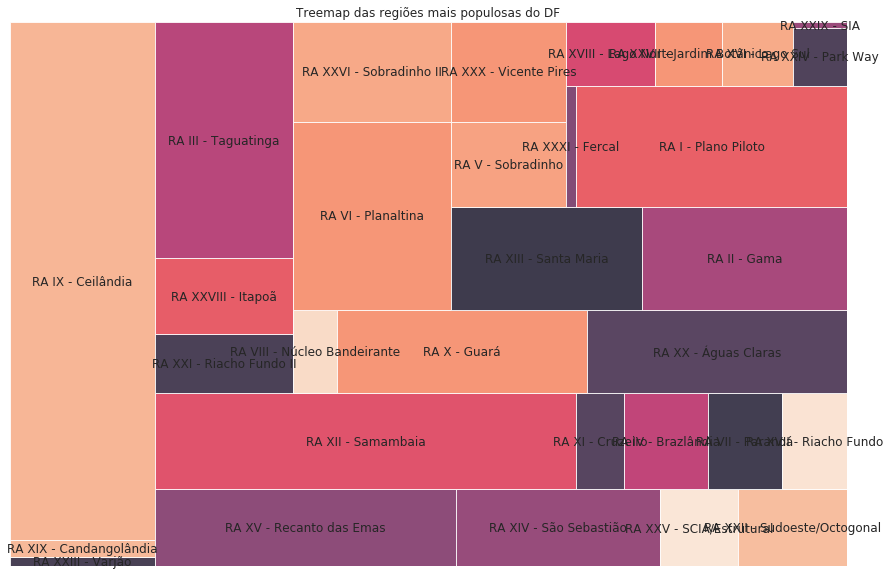

In [63]:
squarify.plot(sizes = df_demografia_2015_2016['População 2015/2016'], label = df_demografia_2015_2016['RA'], alpha = .8 )
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis('off')
plt.title('Treemap das regiões mais populosas do DF')

In [ ]:
df_acidentes_fatais_2008_2017 = df_acidentes_fatais_2008_2017[df_acidentes_fatais_2008_2017['Ano'] == '2016']

In [114]:
def pearson_corr_demografia_acidentes(atributo_demografia):
    acidentes_fatais_por_regiao = df_acidentes_fatais_2008_2017.groupby('Região Administrativa').size().reset_index(name = 'contagem')
    acidentes_fatais_por_regiao = acidentes_fatais_por_regiao.sort_values('contagem', ascending = False)
    
    df_demografia = df_demografia_2015_2016[['RA', atributo_demografia]]
    cidades = df_demografia.RA.str.split(' - ', n = 1, expand = True)
    df_demografia.RA = cidades[1]
    df_demografia.RA = df_demografia.RA.str.upper()
    
    atributo_por_populacao = pd.merge(acidentes_fatais_por_regiao, df_demografia, left_on = 'Região Administrativa', right_on = 'RA')
    
    if atributo_demografia == 'População 2015/2016':
        correlacao_atributo_por_populacao = atributo_por_populacao['contagem'].corr(atributo_por_populacao[atributo_demografia])
    else:
        correlacao_atributo_por_populacao = atributo_por_populacao['contagem'].corr(atributo_por_populacao[atributo_demografia].astype(int))
        atributo_por_populacao[atributo_demografia] = atributo_por_populacao[atributo_demografia].astype(int)
    
    
    print('Valor da correlação: {}'.format(correlacao_atributo_por_populacao))
    sns.regplot(x = 'contagem', y = atributo_demografia, data = atributo_por_populacao, fit_reg = True)
    plt.title("Correlação entre número de acidentes fatais e " + atributo_demografia)
    plt.show()
    

Valor da correlação: 0.914795382608649


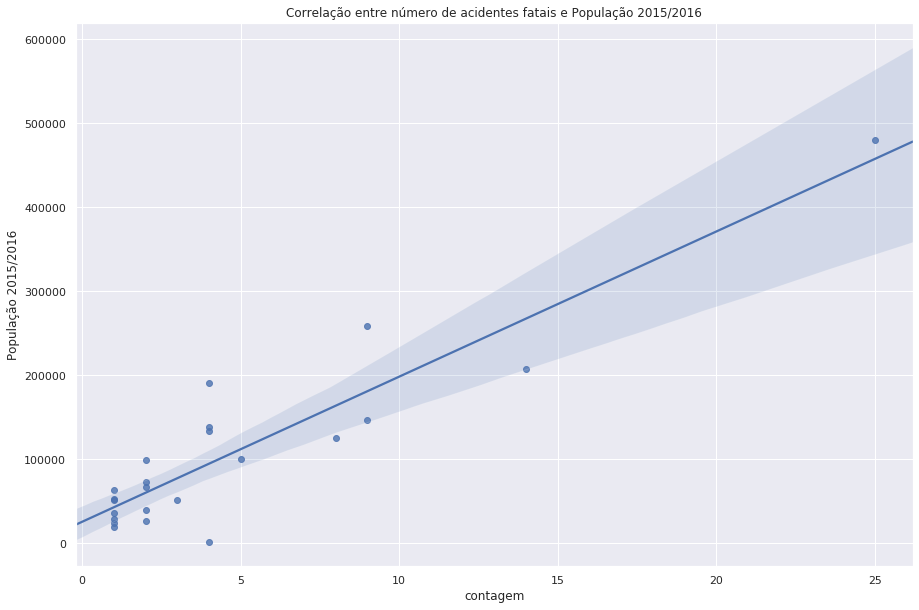

In [115]:
pearson_corr_demografia_acidentes('População 2015/2016')

Valor da correlação: -0.3568240448794187


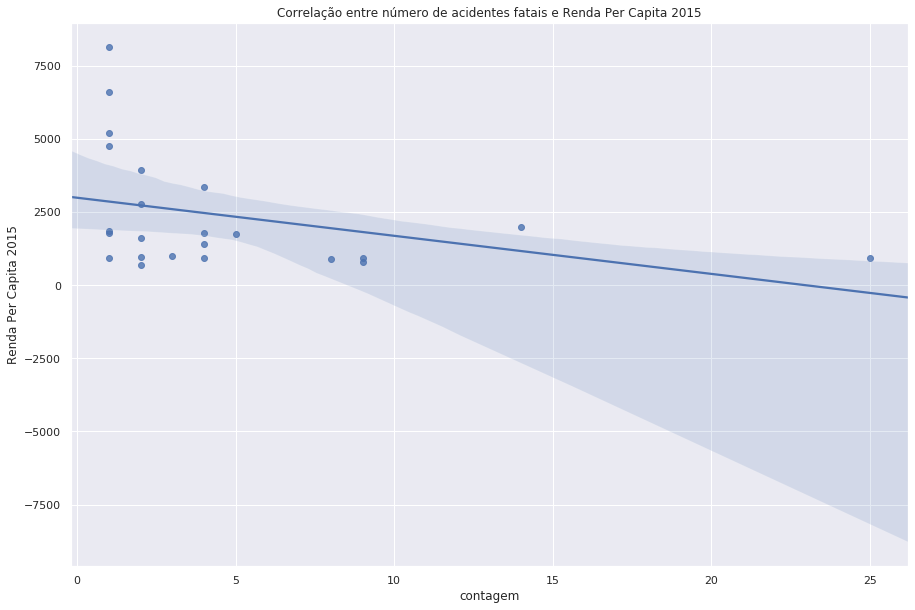

In [116]:
pearson_corr_demografia_acidentes('Renda Per Capita 2015')

Valor da correlação: 0.2949743131325557


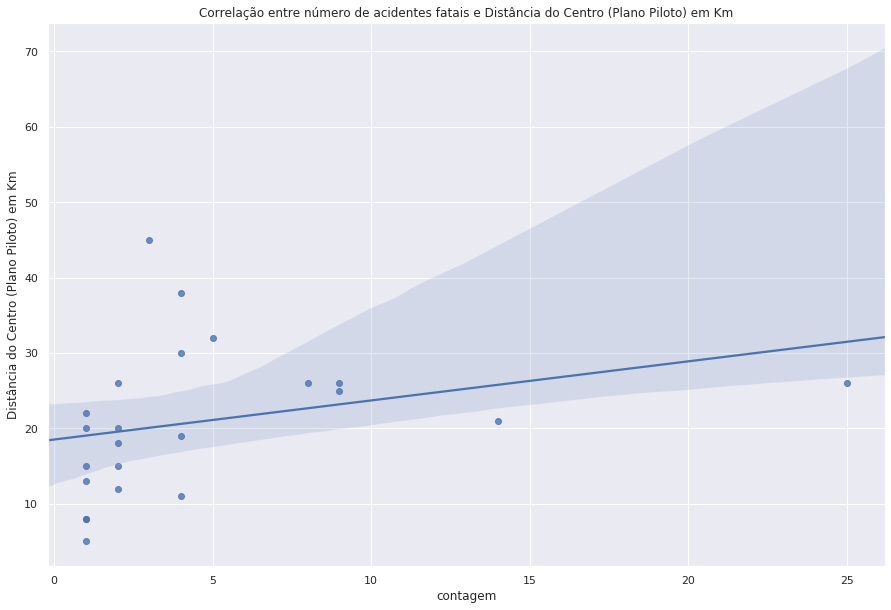

In [117]:
pearson_corr_demografia_acidentes('Distância do Centro (Plano Piloto) em Km')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

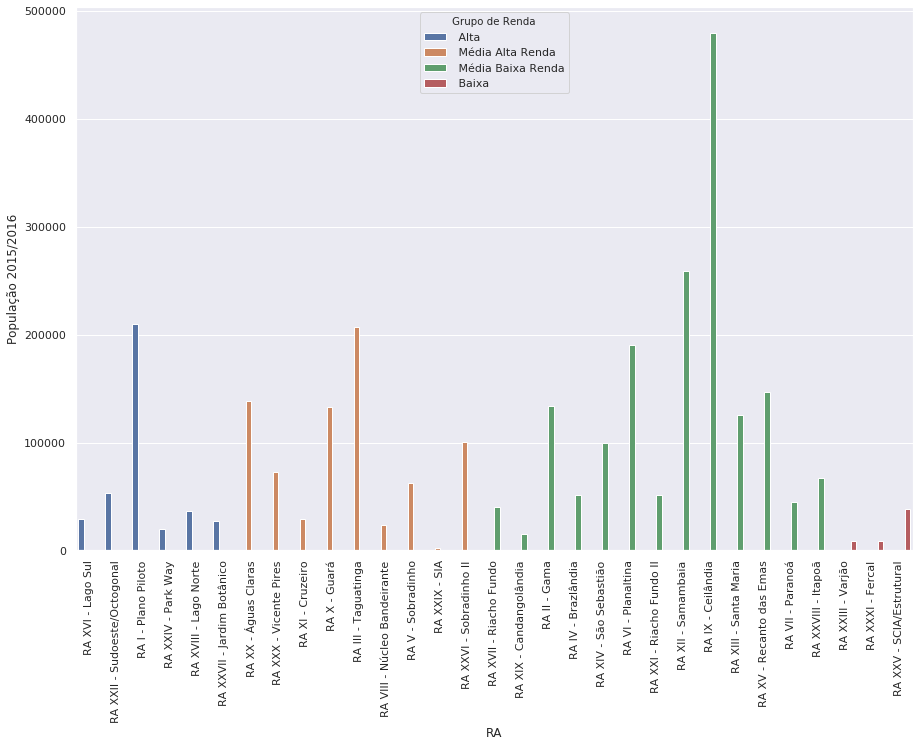

In [108]:
regioes_por_renda = df_demografia_2015_2016.groupby(['RA', 'Renda Per Capita 2015', 'Grupo de Renda', 'População 2015/2016']).size().reset_index().sort_values('Renda Per Capita 2015', ascending = False)
regioes_por_renda
sns.barplot(x = 'RA', y = 'População 2015/2016', hue = 'Grupo de Renda', data = regioes_por_renda)
plt.xticks(rotation = 90)

### Observações

* O número Total de sinalização (somando tipos de sinalização horizontal e vertical) por si só não apresenta resultados significantes em relação ao número de vítimas fatais, visto que as cidades com maiores índices ainda são as que apresentam o maior número de acidentes.
* Brasília (Plano Piloto) apresenta um índice muito elevado quando comparado as outras regiões.
* O valor da densidade de sinalização (calculada através da divisão pelo tamanho em área da região em ha) mostra que as cidades com maiores índices de sinalização por área estão de fato no grupo de cidades com menores índices de acidentes com vítimas fatais.
* Quase todas as regiões com maiores índices de sinalização por área estão no grupo de média-alta/alta renda, com exceção de candagolândia, varjão e riacho fundo (segundo censo 2015/2016) 

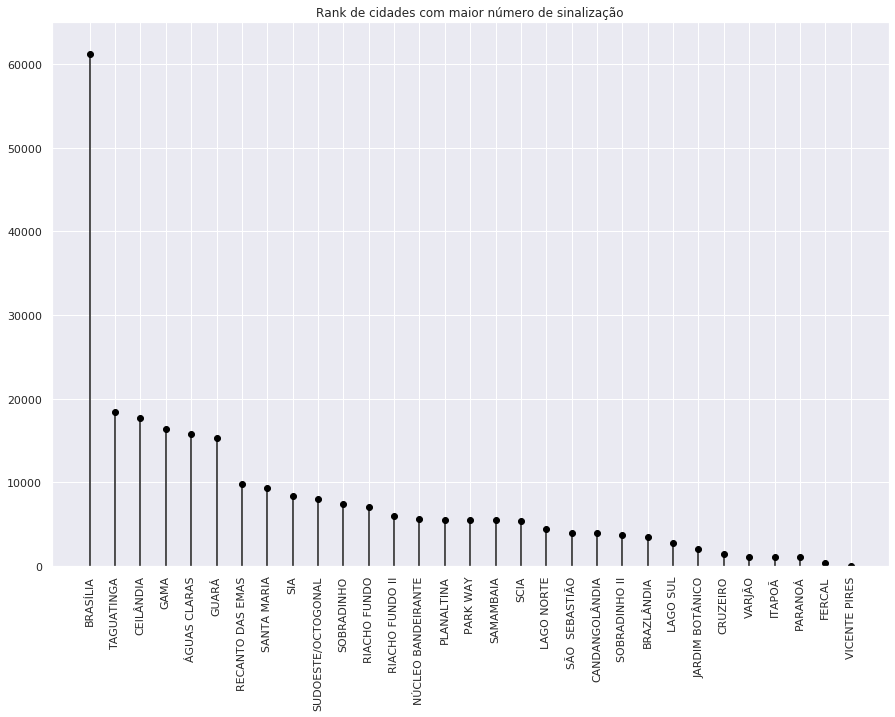

In [38]:
sinalizacao_2018 = df_sinalizacao_2018.groupby(['Região Administrativa', 'Horizontal', 'Vertical']).size().reset_index()
sinalizacao_2018 = sinalizacao_2018[sinalizacao_2018['Região Administrativa'] != 'TOTAL']
sinalizacao_2018.Horizontal = sinalizacao_2018.Horizontal.astype(str).str.replace(',', '.')
sinalizacao_2018.Horizontal = sinalizacao_2018.Horizontal.astype(float).astype(int)
sinalizacao_2018 = sinalizacao_2018.drop(0, axis = 1)
sinalizacao_2018 = sinalizacao_2018.sort_values(['Horizontal', 'Vertical'], ascending = False)
sinalizacao_2018['Total'] = sinalizacao_2018['Horizontal'] + sinalizacao_2018['Vertical']

fig, ax = plt.subplots()
ax.vlines(sinalizacao_2018['Região Administrativa'], ymin = 16, ymax = sinalizacao_2018.Horizontal)
ax.plot(sinalizacao_2018['Região Administrativa'], sinalizacao_2018.Horizontal, "o", color = 'black')
ax.set_ylim(0, 65000)
plt.xticks(rotation = 90)
plt.title('Rank de cidades com maior número de sinalização')
plt.show()

In [19]:
df_demografia = df_demografia_2015_2016
cidades = df_demografia.RA.str.split(' - ', n = 1, expand = True)
df_demografia.RA = cidades[1]
df_demografia.RA = df_demografia.RA.str.upper()

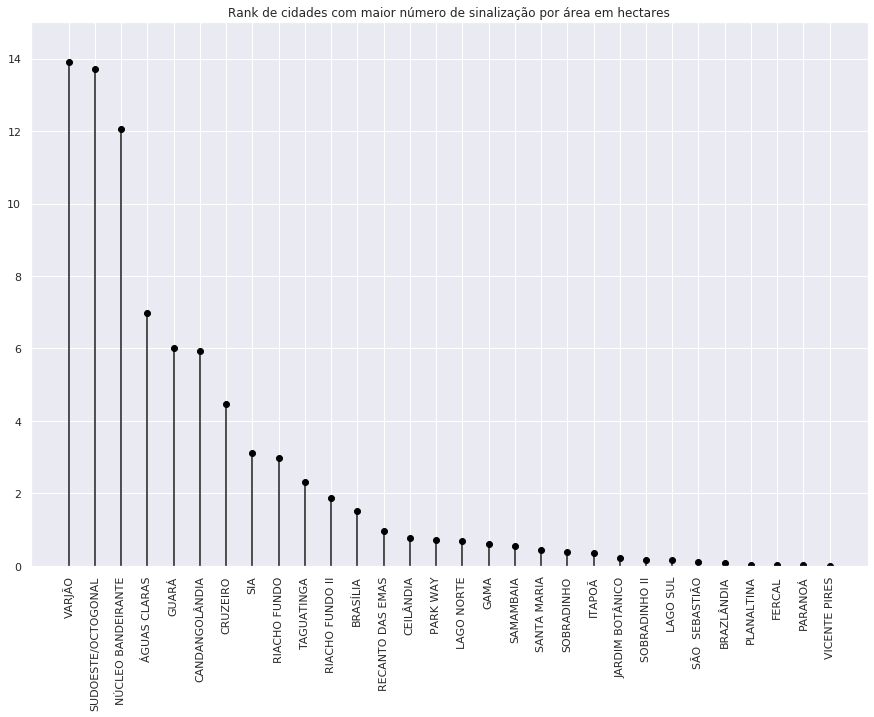

In [43]:
dct = {'PLANO PILOTO': 'BRASÍLIA', 'SÃO SEBASTIÃO': 'SÃO  SEBASTIÃO'}
df_demografia = df_demografia.replace(dct)
df_demografia

sinalizacao_por_area = pd.merge(sinalizacao_2018, df_demografia, left_on = 'Região Administrativa', right_on = 'RA')
sinalizacao_por_area
sinalizacao_por_area['Sinalizacao por área (ha)'] = sinalizacao_por_area['Total'] / sinalizacao_por_area['Área Total da RA (em ha)']
sinalizacao_por_area = sinalizacao_por_area.sort_values(['Sinalizacao por área (ha)'], ascending = False)

fig, ax = plt.subplots()
ax.vlines(sinalizacao_por_area['Região Administrativa'], ymin = 0, ymax = sinalizacao_por_area['Sinalizacao por área (ha)'])
ax.plot(sinalizacao_por_area['Região Administrativa'], sinalizacao_por_area['Sinalizacao por área (ha)'], "o", color = 'black')
ax.set_ylim(0, 15)
plt.xticks(rotation = 90)
plt.title('Rank de cidades com maior número de sinalização por área em hectares')
plt.show()

Text(0.5, 1.0, 'Regiões com maior número de acidentes fatais')

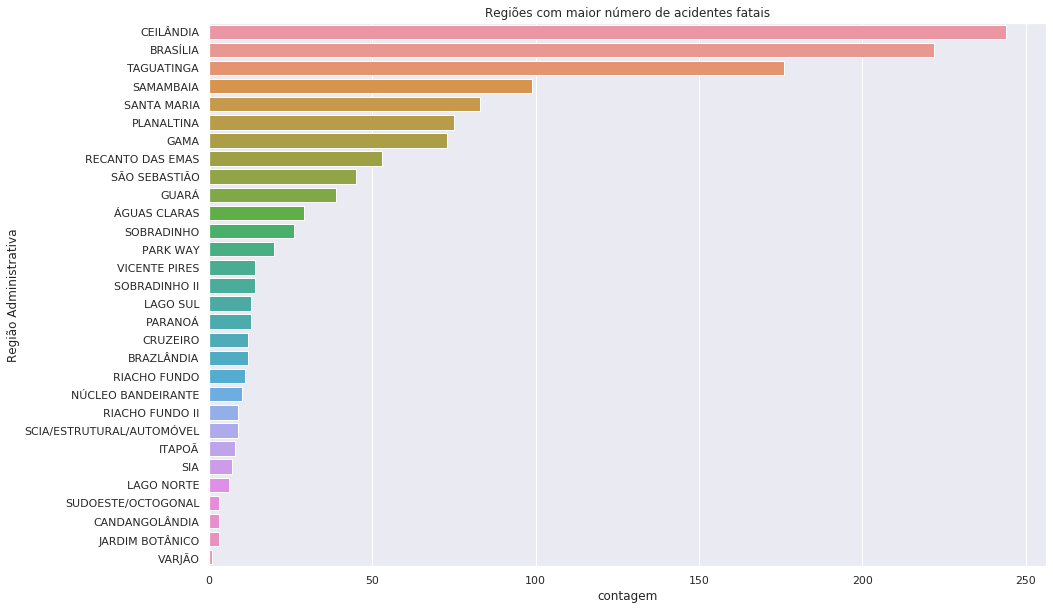

In [83]:
df_acidentes_fatais_2008_2017['Ano'] = df_acidentes_fatais_2008_2017['Ano'].astype(int)

acidentes_fatais_por_regiao = df_acidentes_fatais_2008_2017.groupby('Região Administrativa').size().reset_index(name = 'contagem')
acidentes_fatais_por_regiao = acidentes_fatais_por_regiao.sort_values('contagem', ascending = False)
contagem = acidentes_fatais_por_regiao['contagem']
regioes = acidentes_fatais_por_regiao['Região Administrativa']

sns.barplot(x = contagem, y = regioes, data = acidentes_fatais_por_regiao)
plt.title('Regiões com maior número de acidentes fatais')